In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%tensorflow_version 1.x

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
# print(tf.version)

In [0]:
# Set some parameters
im_width = 1024
im_height = 1024
border = 5

In [0]:
ids = next(os.walk("/content/gdrive/My Drive/avc-dataset/MonuSeg/Training/TissueImages/"))[2] # list of names all images in the given path
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [0]:
#first change
ids_test = next(os.walk("/content/gdrive/My Drive/avc-dataset/MonuSeg/Test/TissueImages/"))[2] # list of names all images in the given path
X_test = np.zeros((len(ids_test), im_height, im_width, 3), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)


In [11]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Training/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (1024, 1024, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0] + '_bin_mask.png'
    mask = img_to_array(load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Training/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [12]:
#2nd change
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Test/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0] + '_bin_mask.png'
    mask = img_to_array(load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Test/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
# Define Some metrics
## Dice Score
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
## F1 Score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [16]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 1024, 1 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 1024, 1024, 1 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 1024, 1024, 1 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [19]:
results = model.fit(X, y, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=(X_test, y_test))



Train on 30 samples, validate on 14 samples
Epoch 1/50
30/30 [==============================] - 58s 2s/step - loss: 0.8090 - acc: 0.5054 - dice_coef: 0.2503 - f1: 0.1479 - val_loss: 0.6132 - val_acc: 0.6397 - val_dice_coef: 0.2602 - val_f1: 0.1560

Epoch 00001: val_loss improved from inf to 0.61317, saving model to model-unet.h5
Epoch 2/50
30/30 [==============================] - 50s 2s/step - loss: 0.6122 - acc: 0.6279 - dice_coef: 0.3411 - f1: 0.2733 - val_loss: 0.5137 - val_acc: 0.7112 - val_dice_coef: 0.3852 - val_f1: 0.4819

Epoch 00002: val_loss improved from 0.61317 to 0.51374, saving model to model-unet.h5
Epoch 3/50
30/30 [==============================] - 58s 2s/step - loss: 0.5215 - acc: 0.7142 - dice_coef: 0.4144 - f1: 0.4902 - val_loss: 0.4448 - val_acc: 0.7698 - val_dice_coef: 0.4599 - val_f1: 0.5884

Epoch 00003: val_loss improved from 0.51374 to 0.44479, saving model to model-unet.h5
Epoch 4/50
30/30 [==============================] - 46s 2s/step - loss: 0.4770 - acc:

In [35]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score,  dice_score = model.evaluate(X_test, y_test, verbose=1)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Dice_score:", dice_score)

14/14 [==============================] - 4s 309ms/step
Loss: 0.2532557547092438
Accuracy: 0.8789369463920593
F1_score: 0.6350167989730835
Dice_score: 0.7300140261650085


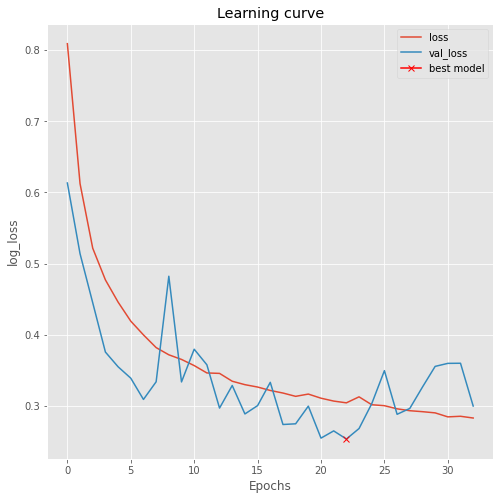

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

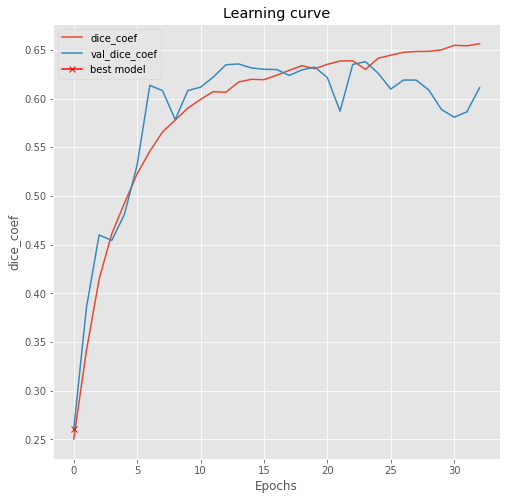

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig("unet_dice_coef.png")

In [23]:
# load the best model
model.load_weights('model-unet.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X, y, verbose=1)

30/30 [==============================] - 7s 247ms/step


[0.285247266292572, 0.8539854884147644, 0.6784944534301758, 0.7644986510276794]

In [24]:
# change 3
# Predict on train, val and test
preds_train = model.predict(X, verbose=1)
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 3s 245ms/step


In [27]:
print (classification_report(y_test.round(0).flatten().astype(int), preds_test.round(0).flatten().astype(int)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94  11781755
           1       0.79      0.70      0.74   2898309

    accuracy                           0.90  14680064
   macro avg       0.86      0.83      0.84  14680064
weighted avg       0.90      0.90      0.90  14680064



In [28]:
TN, FP, FN, TP = confusion_matrix(y_test.flatten().astype(int), preds_test.round(0).flatten().astype(int)).ravel()
Confusion_Matrix = np.array([[TN, FP], [FN, TP]])
print(Confusion_Matrix)

[[11424298   687140]
 [  674389  1894237]]


In [0]:
# change 4
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

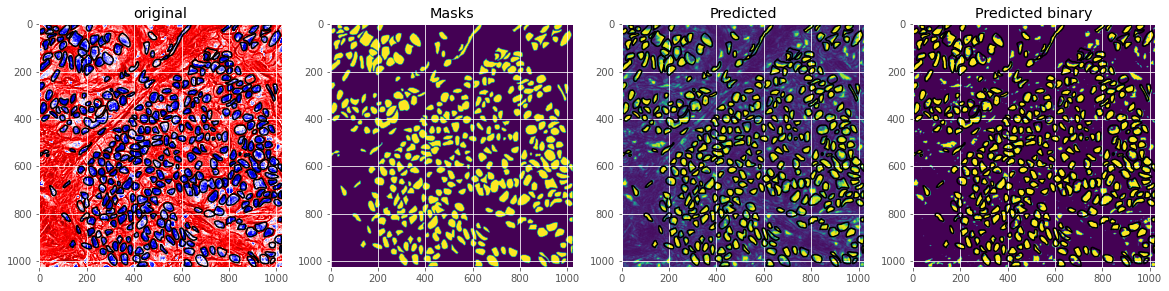

In [31]:
# Check if training data looks all right
plot_sample(X, y, preds_train, preds_train_t, ix=14)

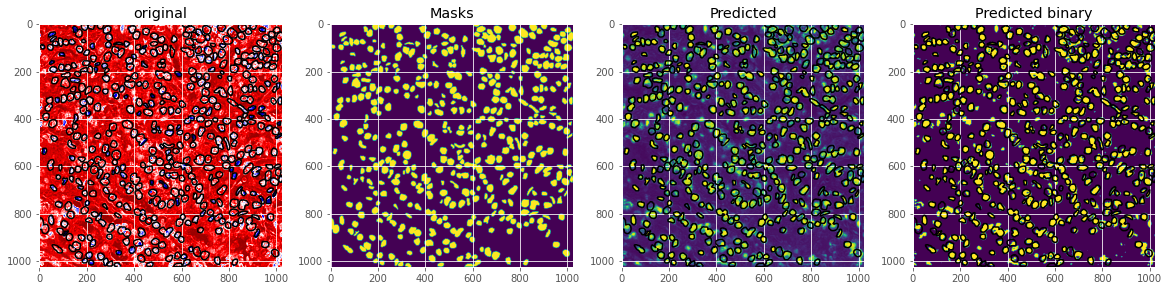

In [32]:
plot_sample(X, y, preds_train, preds_train_t)

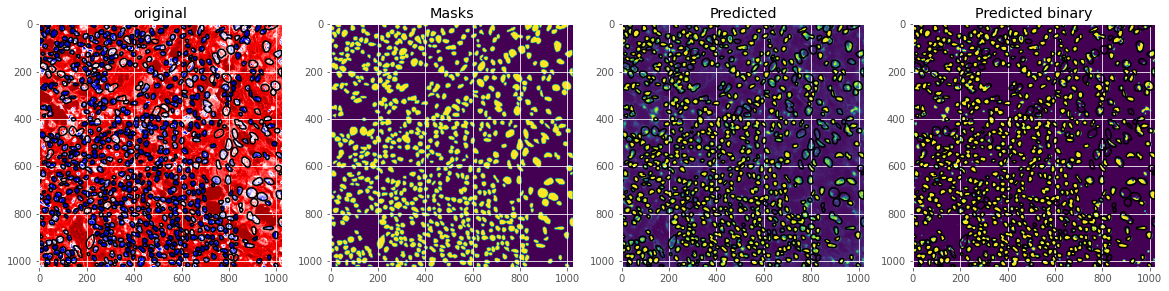

In [33]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)

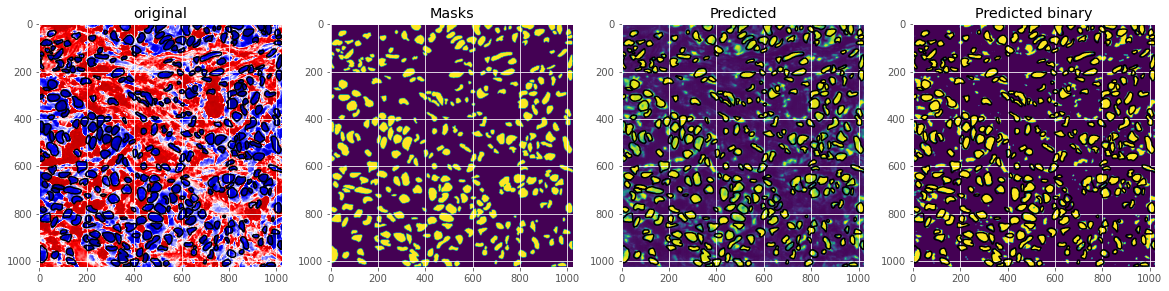

In [34]:
plot_sample(X_test, y_test, preds_test, preds_test_t)